<a href="https://colab.research.google.com/github/jinsusong/study-paper-review/blob/main/02_Google's_Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google's Neural Machine Translation

##Introduction 

1. Old : 16년 이전에는 통계방식으로 혹은 룰 베이스로 기계번역 NLP를 처리했는데

    - Phrase-based translation 을 많이 사용함 : 묶이는 구와 절 단위가 있을 것이다. 그걸 묶어서 번역을 해야한다. 라는 아이디어로 진행하는 아이디어 

    - 문제 : 번역은 입력문장 전체를 입력단위를 두고 번역을 해야 정확한 문법 요소를 파악할 수 있음.

    - 기존의 방식은 구 또는 단어 단위로 독립적으로 번역하기 때문에 정확한 번역을 하기 어렵다. 

    - 어떻게 분리할 것인지도 선택해야하기 때문에 성능을 내기도 어렵다.

2. New : Neural Machine Translation 방식 
    
    - End-to-end learning 방식을 사용
    
    - 간단한 구조를 가지고 있음.

    - 입력된 문장 전부를 보고 번역을 할 수 있다는 장점이 있음.
    



1. Seq2Seq Model (NIPS 2014) 
    - 이 논문을 시작으로 딥러닝 어프로치를 적용시킨 방법론이 나오고 있음.
    - Seq2Seq 방식은 문제가 있음. 
    - 문제 : 굉장히 긴 sequence가 들어온다면 고정된 컨텍스트 벡터로 인해 데이터 유실이 발생됨 

2. Attention Models(2014)
    - Seq2Seq의 Larger vocabulary 한계를 극복하여 성능을 개선한 Paper 



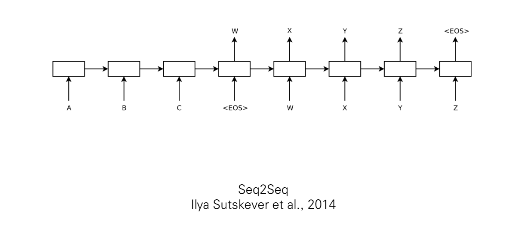

- PBMT : 입력 문장을 단어와 구문으로 분리하여 독립적으로 번역
- NMT : 전체 입력 문장을 번역 단위로 간주


1. 2016년 NMT의 세 가지 단점 
    - 느린 학습/추론 속도
    - 비효율적인 rare words 처리 ( 학습 할 때 몰랐던 단어 ) 
    - Source 문장 coverage

2. GNMT 
    - 제안 : seq2seq + Bahanau attention  + Residual connction 
    - 학습 속도 향상 : model, data parallelism 
    - 추론 속도 향상 : low-precision , clipping
    - Rare words 처리 : Wordpiece subword tokenizer 
    - Source sentence coverage : Beam Search panalty , coverage penalty
    - Performance : BLEU , REINFORCE 

##Related Works

- SMT(통계방식) 번역이 수년간 우세한 번역 paradigm
- 실용적인 구현체는 PBSMT, 이는 다른 길이의 단어 혹은 구(phrase)의 sequence를 번역
- phrase repr를 학습하기 위해 joint language model을 포함한 모델도 성공적 
- learning phrase 표현을 학습하거나 E2E 번역을 배우는 접근도 성공적
- seq2seq, RnnSearch paper에 의하면, NMT 번역 품질은 PBMT 와 비슷한것으로 보임.
- 여러 NMT technique들을 적용하여 성능은 향상되었으나 production 단으로 쓰기에는 부족하고 판단됨.

##Model Architecture

- 모델 구조는 seq2seq 와 동일함
- Bahdanau attention 사용
- 8 replica를 사용하여 data parallelism 실시
- Residual connection 사용
- L to R + R to L information : 양방향의 정보를 활용해서 번역을 하면 성능이 더 향상됨. 첫번째 layer에서만 양방향으로 구축



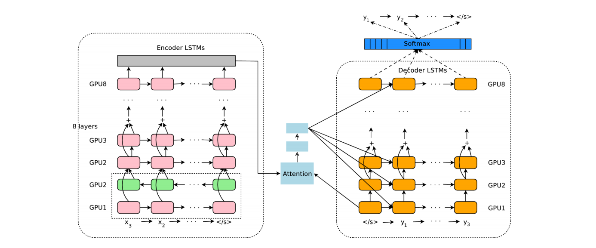

1. Google's Neural Machine Translation 
    - Encoder
        - 8 layer
        - 1st layer 만 bi-directional
        - 3rd layer부터 residual connection 적용
        - LSTM cell
    - Decoder
        - 8 layer
        - 3rd layer부터 residual connection 적용
        - LSTM cell

    - Attention Module 
        - 8th Encoder hidden states와 1st Decoder hidden states로 score 계산(효율적인 병렬 처리)
        - alignment를 최상층의 인코더 레이어 아웃풋과 최하위 디코더 레이어 아웃풋으로 함.
    
    - Data Parallelism
        - n개의 replica를 downpour SGD 알고리즘을 이용하여 학습(여러 모델에서 계산된 gradient를 평균내서 각각의 모델에 적용
        - n개의 replica들은 parameter를 공유하며 Adam + SGD로 update 실시
    
    - Model Parallelism
        - 각 replica 별 gradient computation 속도를 증진시키고자 사용됨 

    

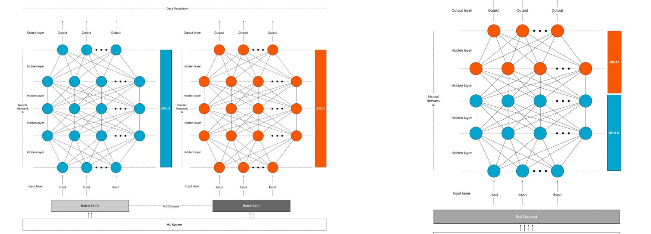


- Model Parallelism
    - Depth dimension에 따라 나눠지고 multiple-GPU에 할당됨
    - 1st Encoder layer를 제외한 모든 계층은 uni-directional이기 때문에 i+1th lyaer는 ith가 완전히 종료되기 전에 계산을 시작할 수 있다 .
    - 본 논문의 model parallelism은 모델 구조로 인한 제약이 존재함.
    - 8th Encoder hidden states와 1st Decoder hidden statesfh score 계산 

- 왜 첫번째 layer만 bidirection을 사용하는가? 
    - bidirection을 사용하면 병렬 GPU의 이점을 소실함.
    - 때문에 첫번째 layer만 구축을 함 

- 인코더의 마지막 layer와 디코더의 첫번째 layer만 alignment를 했는가? 
    - 병렬화의 극대화를 위해서 사용함



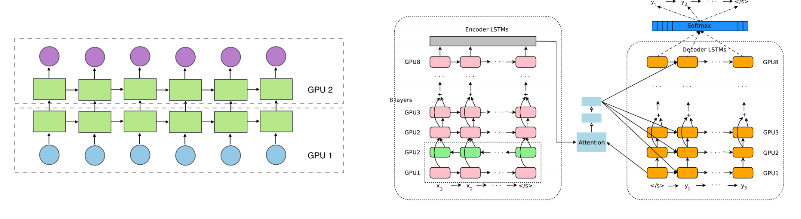

## Segmentation Approaches

- MNT에선 open vocabulary problem이 있지만 fixed word vocabulary로 연산함 

- oov를 어떻게 처리할 것인가? (학습하지 않은 단어에 대한것을 어떻게 처리할지)
    1. Copy model-based
    
        - 가장 비슷한 단어를 사용
        
        - 사전에 있는 것을 복사해서 출력으로 전달 
    
    2. subword units

        - 문자 단위로 쪼개서 구성

        - Wordpice Model은 subword units를 활용하는 방법론
            1. 충분히 많은 training data(corpus)를 준비 
            2. Desired subword vocabulary size를 저으이
            3. 단어를 character의 sequence로 분해 
            4. Step 3의 데이터를 기반으로 LM 구축
            5. 모델에 추가될 때 training data에 대한 likelihood를 가장 많이 증가시키는 모든 가능한 단어 중에서 새로운 단어 단위를 선택
            6. Step 2에서 정의된 subword vocabulary size에 도달하거나 likelihood증가가 특정 임계값 아래로 떨어질 때 까지 STep 5 반복

        - Character 단위로 분리 후 언어 모델을 학습,  결합되었을 때 likelihood를 maximize하는 경우! 추가하도록 함 
        - BPE랑은 다른 알고리즘 
            - BPE는 character 단위로 분리 후 등장 빈도에 따라 결합하는 과정을 n회 반복하는 알고리즘
            - Sennrich의 addressing rare word paper에서 적용된 알고리즘
            - GPT-2 tokenizer이기도 함 




## Training Criteria

In [ ]:
- BLUE score 는 많이 올랐지만 
- Human 평가에서는 성능이 좋지 않았다 .
- 


##Decoder 

- Beam Search : Greedy Decoding과 모든 경우의 수를 고려하는 방법의 타협점
    - Max-probability based method
    - Greedy Decoding: seq2seq에서 단순하게 해당 시점에서 가장 확률이 높은 후보를 선택하는 것
    - 특정 시점 t에서의 확률 분포 상에서 상위 1등과 2등의 확률 차이가 작든 크든, Greedy Decoding 방식은 무조건 가장 큰 놈에게만 관심이 있을 뿐
    - 1등과 2등의 차이가 정말 미묘하다면,  2등이 정답일 경우도 고려해주어야 할 것

    



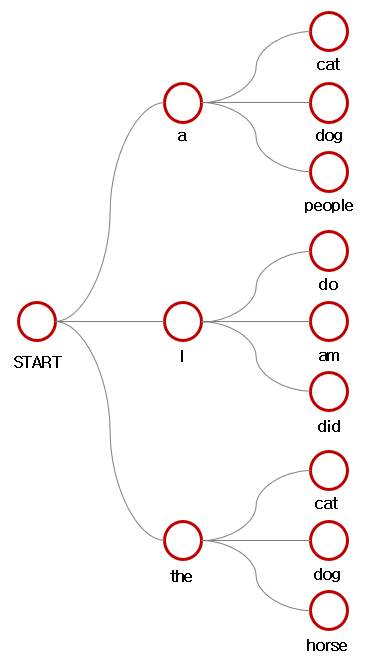

참고 : https://www.youtube.com/watch?v=5rKKJcsL8fU